In [1]:
import time
import os
import logging
from pathlib import Path
import datetime
from config import config
from gpt_model import get_completion_from_gpt
from claude import get_completion_from_claude
from ollama import get_completion_from_ollama
from format_output import Format_output
import pandas as pd
import matplotlib.pyplot as plt
import csv
import re
import seaborn as sns
from math import pi
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
import numpy as np
import nltk
from rouge import Rouge
from nltk.metrics import edit_distance
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from nltk.translate.bleu_score import sentence_bleu
import pandas as pd
import matplotlib.cm as cm
import matplotlib.colors as mcolors

In [ ]:
# Set the ROOT_DIR to your repository root.
ROOT_DIR = os.path.dirname(os.path.abspath(''))
# Set the DATA_DIR to the directory where your data resides.
DATA_DIR = os.path.join(ROOT_DIR, 'data/loghub_2k')
save_dir_path = os.path.join(ROOT_DIR, 'results')

In [3]:
llm_model_name = "gpt3.5_turbo" # change this everytime with new model
# Model options - deepseek-coder-v2, deepseek-v2:16b, codegemma:7b, qwen2.5-coder:7b, codellama:7b

save_dir_path = os.path.join(ROOT_DIR, 'results')
now_time = datetime.datetime.now()
date_string = "Semantic_" + llm_model_name + now_time.strftime('_%Y-%m-%d-%H-%M')
save_dir_path = os.path.join(ROOT_DIR, 'results')

save_dir_path_now = os.path.join(save_dir_path, date_string)

raw_save_dir_path = os.path.join(save_dir_path_now, "raw_results/")
Path(raw_save_dir_path).mkdir(parents=True, exist_ok=True)

log_templates_output_file_name = 'log_template_output.txt'
variables_output_file_name = 'variables_output.csv'


semantic_prompts_file_path = os.path.join(raw_save_dir_path, "semantic_prompts.txt")
log_templates_output_file_path = raw_save_dir_path + log_templates_output_file_name
variables_output_file_path = raw_save_dir_path + variables_output_file_name


In [3]:
# File paths
ground_truth_file_path = os.path.join(DATA_DIR, "ground_truth_template.csv")
raw_logs_file_path = os.path.join(DATA_DIR, "combined_raw_logs.txt")

In [5]:
# Load raw log messages
with open(raw_logs_file_path, 'r') as raw_file:
    log_samples = [line.strip() for line in raw_file.readlines()]


In [7]:
# Step 1: Reformulate log messages with semantic understanding
counter=0
semantic_prompts = []
for log in log_samples:
    prompt=f"""You are provided with a log message. Your task is to understand and extract the meaning behind the semi-structured log message.
                      
                    Log message: {log}. 

                    A log message usually contains a header that is automatically produced by the logging framework, including information such as timestamp, class, and logging level (INFO, DEBUG, WARN etc.).
                    Ignore all these details and just understand meaning behind the natural languagae text which is in the log content.

                    The log content typically consists of many parts: 
                    1. Template - message body, that contains constant strings (or keywords) describing the system events; 
                    2. Parameters/Variables - dynamic variables, which reflect specific runtime status;

                    Please capture the essential context and meaning from the log message to understand the reasoning behind each raw log.
                    Provide only the meaning in just one sentence from each log message surrounded by <TPL> and </TPL> in a single line.
                    Never provide any text other than just the understanding from the log message
                """
    
    semantic_prompt = get_completion_from_gpt(prompt)
    # semantic_prompt = get_completion_from_ollama(prompt, model=llm_model_name)
    semantic_prompts.append(semantic_prompt)
    if counter % 10 == 0:
        print(f'{counter}: {semantic_prompt}')
    counter+=1    


0: <TPL> Unable to locate child process with ID 5622 in the system scoreboard during initialization of jk2. </TPL>
10: <TPL> The log indicates that node-129 has initiated the action of starting the boot process for the system. </TPL>
20: <TPL> A ServerFileSystem domain panic has occurred on storage442. </TPL>
30: <TPL> The partition with ID 1126818053 is full and is being closed. </TPL>
40: <TPL> The temperature of gige4 port is at a warning level. </TPL>
50: <TPL> Node node-73 detected an available network connection on network 0.0.0.0 via interface alt0. </TPL>
60: <TPL> User 'root' successfully logged in to the system. </TPL>
70: <TPL> The cupsd service was successfully shut down. </TPL>
80: <TPL> The syslogd service was restarted. </TPL>
90: <TPL> The system successfully started the klogd service. </TPL>
100: <TPL> The kernel command line specifies read-only root with the label "/" and enables Red Hat graphical boot and quiet mode. </TPL>
110: <TPL> The system console is set to dis

In [8]:
print(len(semantic_prompts))

1146


In [9]:
# save and format output data in a csv file
Format_output.save_raw_output(semantic_prompts_file_path, semantic_prompts)
# convert raw output into formatted file 
Format_output.remove_TPL_from_output(semantic_prompts_file_path, semantic_prompts_file_path)

# Save all semantic log templates to a file
print(f"Semantics from logs saved to: {semantic_prompts_file_path}")

Processed output saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_gpt3.5_turbo_2024-12-12-00-24/raw_results/semantic_prompts.txt
Semantics from logs saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_gpt3.5_turbo_2024-12-12-00-24/raw_results/semantic_prompts.txt


In [10]:
# Step 2: Generate log template using 4-shot learning
counter_1 = 0
semantic_based_log_templates = []
for log, semantic_prompt in zip(log_samples, semantic_prompts):
    prompt = f"""You will be given a log message enclosed by <MSG> and </MSG> tags, along with its semantic understanding: {semantic_prompt}.

                The log message consists of:
                1. A log_template (message body, that contains constant strings (or keywords) describing the system events.)
                2. Dynamic variables (dynamic variables, which reflect specific runtime status.)

                Your task is to:
                - Identify all dynamic variables in the log message.
                - Only Replace each dynamic variable with a placeholder surrounded by angle brackets, like <*>, to produce a log_template.
                - Output only log_template, enclosed in <TPL> and </TPL> tags.
                - The final output must be a single line with no leading/trailing spaces, no extra lines, and no explanations.

                Here are examples:

                Q: <MSG>[081109 204453 34 INFO dfs.FSNamesystem: BLOCK* NameSystem.addStoredBlock: blockMap updated: 10.250.11.85:50010 is added to blk_2377150260128098806 size 67108864]</MSG>  
                A: <TPL>[BLOCK* NameSystem.addStoredBlock: blockMap updated: <*>:<*> is added to <*> size <*>]</TPL>

                Q: <MSG>- 1129734520 2005.10.19 R17-M0-N0-I:J18-U01 2005-10-19-08.08.40.058960 R17-M0-N0-I:J18-U01 RAS KERNEL INFO shutdown complete</MSG>  
                A: <TPL>shutdown complete</TPL>

                Q: <MSG>20231114T101914E ERROR 14 while processing line 123: cannot find input '42'</MSG>  
                A: <TPL>ERROR <*> while processing line <*>: cannot find input <*></TPL>

                Q: <MSG>2023-01-14 23:05:14 INFO: Reading data from /user/input/file.txt</MSG>  
                A: <TPL>Reading data from <*></TPL>

                Now, consider the following log message: <MSG>{log}</MSG>  
                Using the same process as above, output only the single-line log_template enclosed in <TPL> and </TPL>, and nothing else.
            """
    response = get_completion_from_gpt(prompt)
    # response = get_completion_from_ollama(prompt, model=llm_model_name)
    semantic_based_log_templates.append(response)
    if counter_1 % 10 == 0:
        print(f'{counter_1}: {response}')
    counter_1+=1    

0: <TPL>jk2_init() Can't find child <*> in scoreboard</TPL>
10: <TPL>node-<*> action start <*> <*> bootGenvmunix  (command <*>)</TPL>
20: <TPL>An ServerFileSystem domain panic has occurred on storage442</TPL>
30: <TPL>full partition status <*> <*> closing</TPL>
40: <TPL><*> gige temperature <*> <*> warning</TPL>
50: <TPL>NIFF: node node-73 has detected an available network connection on network <*> via interface alt0</TPL>
60: <TPL>session opened for user <*> by LOGIN(uid=*)</TPL>
70: <TPL>cupsd shutdown succeeded</TPL>
80: <TPL>combo syslogd <*>: restart.</TPL>
90: <TPL>klogd startup succeeded</TPL>
100: <TPL>Kernel command line: ro root=LABEL=/ rhgb quiet</TPL>
110: <TPL>Console: colour VGA+ 80x25</TPL>
120: <TPL><*> rpcidmapd: rpc.idmapd startup succeeded</TPL>
130: <TPL>Enabling unmasked SIMD FPU exception support... done.</TPL>
140: <TPL>Linux Plug and Play Support v<*> (c) Adam Belay</TPL>
150: <TPL>apm: BIOS version <*> Flags <*> (Driver version <*>)</TPL>
160: <TPL>Bringing up 

In [28]:
print(len(semantic_based_log_templates))

# save and format output data in a csv file
Format_output.save_raw_output(log_templates_output_file_path, semantic_based_log_templates)
# convert raw output into formatted file 
Format_output.remove_TPL_from_output(log_templates_output_file_path, log_templates_output_file_path)

1146
Processed output saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_gpt3.5_turbo_2024-12-12-00-24/raw_results/log_template_output.txt


In [5]:
# File paths
processed_log_templates_file_path = "/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_qwen2.5-coder:7b_2024-12-11-16-02/raw_results/log_template_output.txt"

# Load ground truth data
ground_truth_df = pd.read_csv(ground_truth_file_path)
ground_truth_log_templates = ground_truth_df['EventTemplate'].tolist()
ground_truth_systems = ground_truth_df['System'].tolist()

output_directory = os.path.dirname(processed_log_templates_file_path)


# Load processed output data
with open(processed_log_templates_file_path, 'r') as processed_file:
    processed_log_templates = [line.strip() for line in processed_file.readlines()]
 

# Ensure the lists are of the same length for comparison
min_length = min(len(ground_truth_log_templates), len(processed_log_templates))
ground_truth_log_templates = ground_truth_log_templates[:min_length]
processed_log_templates = processed_log_templates[:min_length]
ground_truth_systems = ground_truth_systems[:min_length]

# Calculate evaluation metrics for processed_log_templates
precision = precision_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
recall = recall_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)
f1 = f1_score(ground_truth_log_templates, processed_log_templates, average='weighted', zero_division=0)

# Print evaluation metrics for processed_log_templates
print(f"Log Templates Precision: {precision * 100:.2f}%")
print(f"Log Templates Recall: {recall * 100:.2f}%")
print(f"Log Templates F1 Score: {f1 * 100:.2f}%")

Log Templates Precision: 18.76%
Log Templates Recall: 18.67%
Log Templates F1 Score: 18.67%


In [6]:
# Calculate correctly parsed log templates for each system
correct_parsed_counts = {}
for system, gt_template, processed_template in zip(ground_truth_systems, ground_truth_log_templates, processed_log_templates):
    if gt_template == processed_template:
        if system not in correct_parsed_counts:
            correct_parsed_counts[system] = 0
        correct_parsed_counts[system] += 1

# Print correctly parsed log templates for each system
print("\nCorrectly Parsed Log Templates per System:")
total=0
for system, count in correct_parsed_counts.items():
    total +=count
    print(f"{system}: {count}")

print(f"Total correctly parsed log templates: {total}")


Correctly Parsed Log Templates per System:
HPC: 2
Linux: 29
Zookeeper: 17
BGL: 17
Hadoop: 23
Mac: 50
HealthApp: 28
OpenSSH: 1
Spark: 8
HDFS: 2
OpenStack: 14
Thunderbird: 23
Total correctly parsed log templates: 214


In [10]:
# Ensure that NLTK and other required libraries are installed
nltk.download('punkt_tab')

# Description of Metrics
print("Description of Metrics:\n")
print("Edit Distance: Measures the number of character-level edit operations (insertion, deletion, substitution) needed to transform one string into another. A normalized score between 0 and 1 is calculated by dividing the edit distance by the total character length of the longer string, where 0 indicates identical strings and 1 indicates completely different strings.\n")
print("ROUGE-L: Measures the similarity between two texts based on the longest common subsequence. The score ranges from 0 to 1, with 1 indicating high similarity. ROUGE-L focuses on recall and is useful for comparing the structure of sentences.\n")
print("Cosine Similarity: Measures the cosine of the angle between two vectors, which represent the texts in a multi-dimensional space. The score ranges from 0 to 1, with 1 indicating that the vectors are identical, meaning high similarity.\n")
print("BLEU (Bilingual Evaluation Understudy): Measures the similarity between a predicted sentence and one or more reference sentences by calculating the overlap of n-grams. The score ranges from 0 to 1, with 1 indicating high similarity. BLEU is commonly used for machine translation evaluation.\n")

# 1. Edit Distance for Each System
def calculate_edit_distance_for_each_system(ground_truth_list, processed_list, system_list):
    system_distances = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        distance = edit_distance(gt, processed)
        max_length = max(len(gt), len(processed))
        normalized_distance = distance / max_length if max_length > 0 else 0
        if system not in system_distances:
            system_distances[system] = []
        system_distances[system].append(normalized_distance)
    
    avg_distances = {}
    for system, distances in system_distances.items():
        avg_distance = sum(distances) / len(distances)
        avg_distances[system] = avg_distance
        print(f"System '{system}': Normalized Average Edit Distance = {avg_distance:.2f} (Range: 0 to 1, where lower is better)")
    
    return avg_distances

# 2. ROUGE-L Score for Each System
def calculate_rouge_l_for_each_system(ground_truth_list, processed_list, system_list):
    rouge = Rouge()
    system_rouge_scores = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        if not gt.strip() or not processed.strip():
            continue  # Skip empty ground truth or processed templates
        scores = rouge.get_scores(processed, gt, avg=True)
        rouge_l_score = scores['rouge-l']['f']
        if system not in system_rouge_scores:
            system_rouge_scores[system] = []
        system_rouge_scores[system].append(rouge_l_score)
    
    avg_rouge_scores = {}
    print("\nAverage ROUGE-L Score Range: 0 to 1, where 1 means highly similar")
    for system, rouge_scores in system_rouge_scores.items():
        avg_rouge_score = sum(rouge_scores) / len(rouge_scores)
        avg_rouge_scores[system] = avg_rouge_score
        print(f"System '{system}':              Average ROUGE-L Score = {avg_rouge_score:.2f}")
    
    return avg_rouge_scores

# 3. Cosine Similarity for Each System
def calculate_cosine_similarity_for_each_system(ground_truth_list, processed_list, system_list):
    vectorizer = TfidfVectorizer()
    system_cosine_scores = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        if not gt.strip() or not processed.strip():
            continue  # Skip empty ground truth or processed templates
        vectors = vectorizer.fit_transform([gt, processed])
        cosine_sim = cosine_similarity(vectors[0], vectors[1])[0][0]
        if system not in system_cosine_scores:
            system_cosine_scores[system] = []
        system_cosine_scores[system].append(cosine_sim)
    
    avg_cosine_scores = {}
    print("\nAverage Cosine Similarity Score Range: 0 to 1, where 1 means highly similar")
    for system, cosine_scores in system_cosine_scores.items():
        avg_cosine_score = sum(cosine_scores) / len(cosine_scores)
        avg_cosine_scores[system] = avg_cosine_score
        print(f"System '{system}':              Average Cosine Similarity Score = {avg_cosine_score:.2f}")
    
    return avg_cosine_scores


# 4. BLEU Score for Each System
def calculate_bleu_for_each_system(ground_truth_list, processed_list, system_list):
    system_bleu_scores = {}
    for system, gt, processed in zip(system_list, ground_truth_list, processed_list):
        reference_tokens = nltk.word_tokenize(gt)
        hypothesis_tokens = nltk.word_tokenize(processed)
        bleu_score = sentence_bleu([reference_tokens], hypothesis_tokens)
        if system not in system_bleu_scores:
            system_bleu_scores[system] = []
        system_bleu_scores[system].append(bleu_score)
    
    avg_bleu_scores = {}
    print("\nAverage BLEU Score Range: 0 to 1, where 1 means highly similar")
    for system, bleu_scores in system_bleu_scores.items():
        avg_bleu_score = sum(bleu_scores) / len(bleu_scores)
        avg_bleu_scores[system] = avg_bleu_score
        print(f"System '{system}':              Average BLEU Score = {avg_bleu_score:.2f}")
    
    return avg_bleu_scores

# Calculating metrics for the given log templates
print("Comparing the processed log templates to the ground truth log templates:\n")
edit_distances = calculate_edit_distance_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)
rouge_l_scores = calculate_rouge_l_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)
cosine_similarity_scores = calculate_cosine_similarity_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)
bleu_scores = calculate_bleu_for_each_system(ground_truth_log_templates, processed_log_templates, ground_truth_systems)



[nltk_data] Downloading package punkt_tab to
[nltk_data]     /Users/navneetsharma/nltk_data...
[nltk_data]   Package punkt_tab is already up-to-date!


Description of Metrics:

Edit Distance: Measures the number of character-level edit operations (insertion, deletion, substitution) needed to transform one string into another. A normalized score between 0 and 1 is calculated by dividing the edit distance by the total character length of the longer string, where 0 indicates identical strings and 1 indicates completely different strings.

ROUGE-L: Measures the similarity between two texts based on the longest common subsequence. The score ranges from 0 to 1, with 1 indicating high similarity. ROUGE-L focuses on recall and is useful for comparing the structure of sentences.

Cosine Similarity: Measures the cosine of the angle between two vectors, which represent the texts in a multi-dimensional space. The score ranges from 0 to 1, with 1 indicating that the vectors are identical, meaning high similarity.

BLEU (Bilingual Evaluation Understudy): Measures the similarity between a predicted sentence and one or more reference sentences by cal

/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/.venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/.venv/lib/python3.9/site-packages/nltk/translate/bleu_score.py:577: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/.venv/lib/python3.9/site-packages/nltk/translate/bleu_

In [11]:
print(f'Avg. Edit Distance: {sum(edit_distances.values())/len(edit_distances)}')
print(f'Avg. Rouge-l Score: {sum(rouge_l_scores.values())/len(rouge_l_scores)}')
print(f'Avg. Cosine Similarity: {sum(cosine_similarity_scores.values())/len(cosine_similarity_scores)}')
print(f'Avg. BLEU Score: {sum(bleu_scores.values())/len(bleu_scores)}')

Avg. Edit Distance: 0.30389242532515665
Avg. Rouge-l Score: 0.7094343757975378
Avg. Cosine Similarity: 0.7346309642700103
Avg. BLEU Score: 0.5226735006342528


In [15]:
evaluation_metrices_results = 'gpt_semantic_combined_evaluation-log_templates_results.csv'
evaluation_metrices_results_file_path = os.path.join(save_dir_path, evaluation_metrices_results)

# Storing results into a CSV file
all_results = []

# Add Syntactic results
for system in ground_truth_systems:
    all_results.append({
        "Parsing Technique": "Semantic",
        "LLM Model": llm_model_name,
        "System": system,
        "Edit Distance": edit_distances.get(system, None),
        "ROUGE-L": rouge_l_scores.get(system, None),
        "Cosine Similarity": cosine_similarity_scores.get(system, None),
        "BLEU": bleu_scores.get(system, None),
    })

# Convert results to a DataFrame and save to CSV
df_results = pd.DataFrame(all_results)
df_results.to_csv(evaluation_metrices_results_file_path, index=False)

print(f"Evaluation metrics saved to {evaluation_metrices_results_file_path}")


Evaluation metrics saved to /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/gpt_semantic_combined_evaluation-log_templates_results.csv


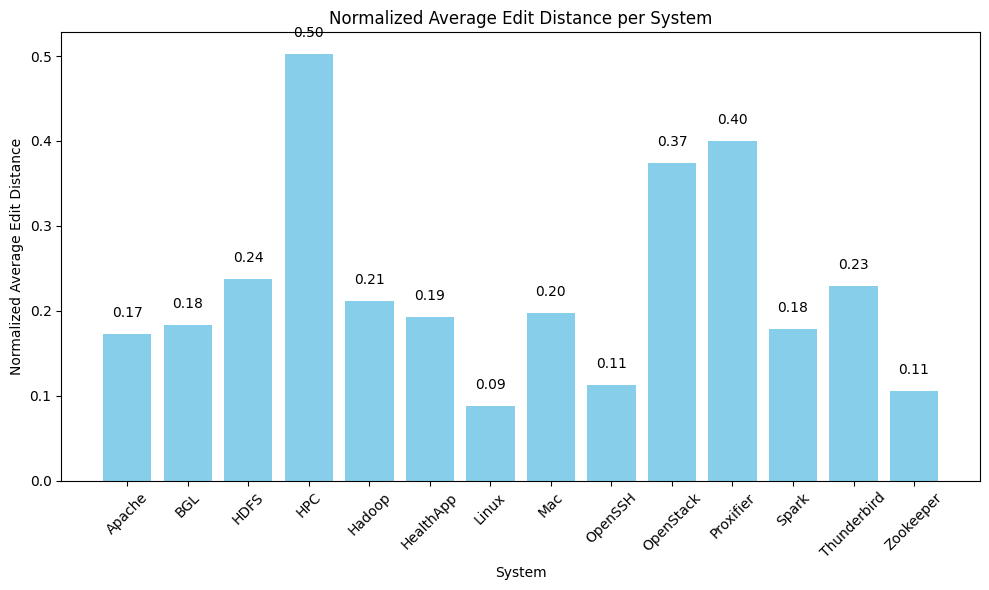

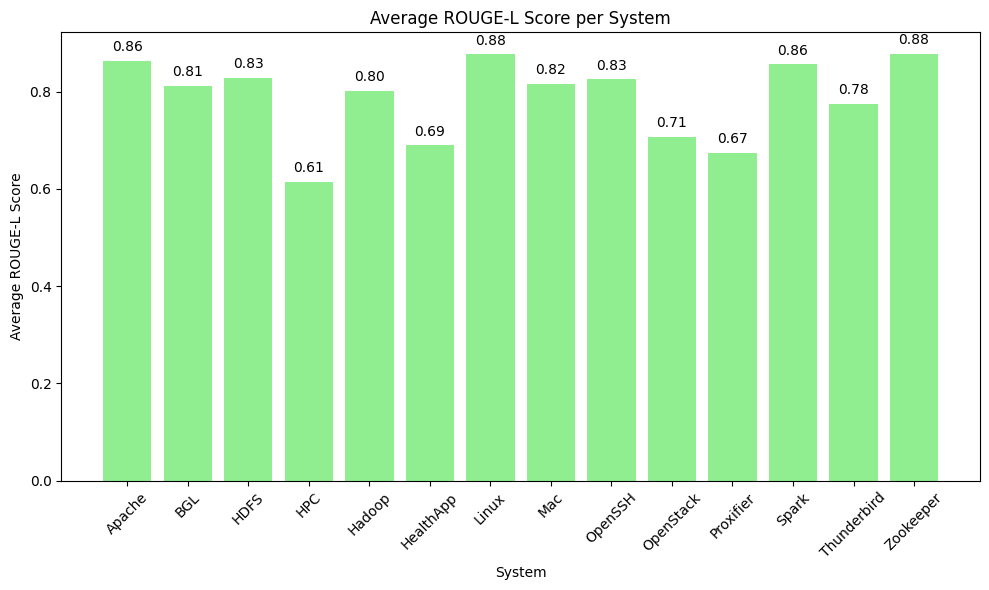

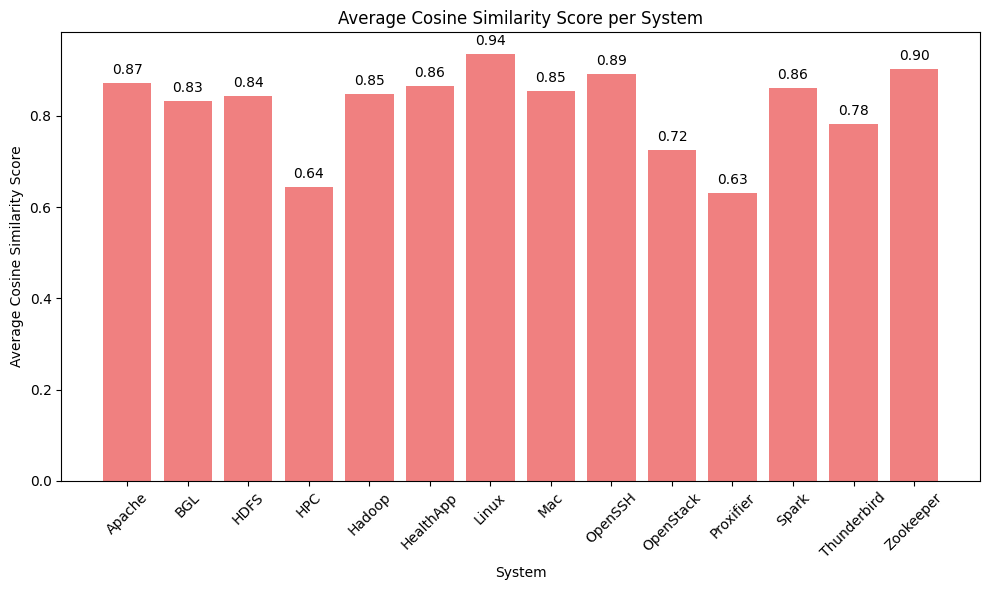

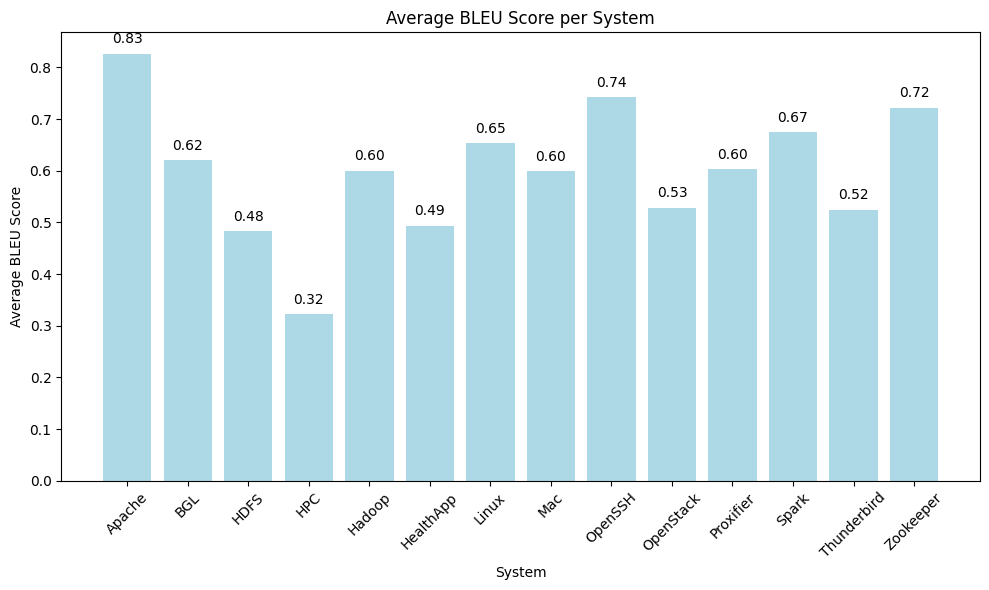

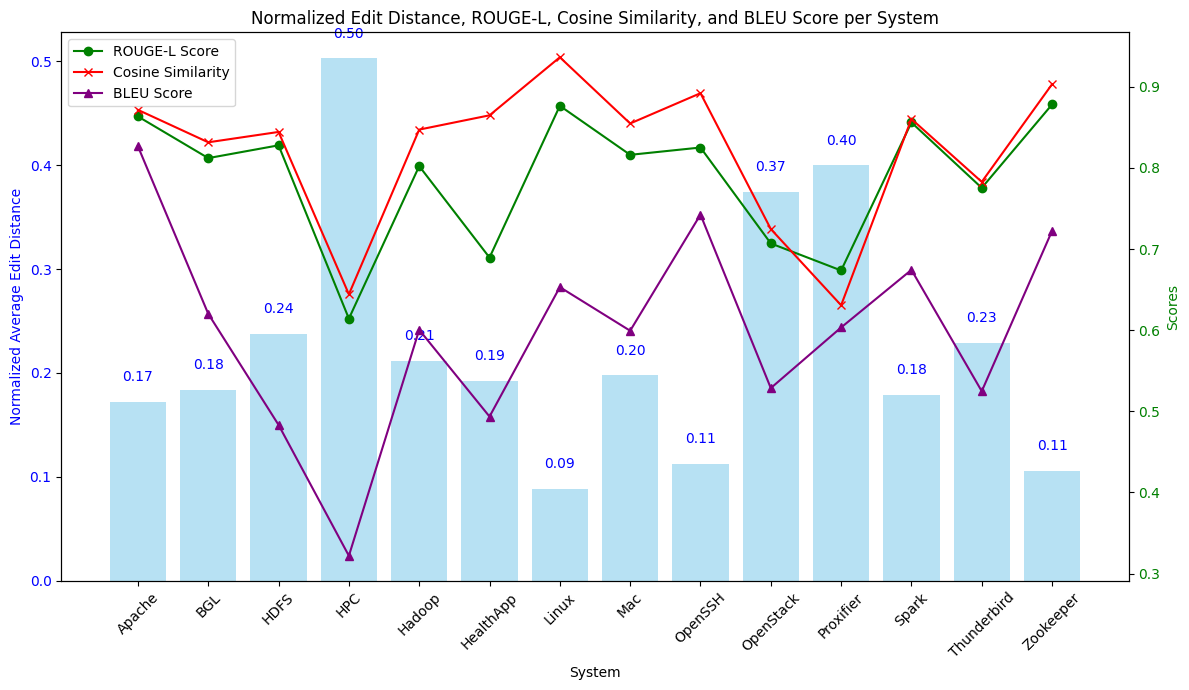

In [16]:
import os
import matplotlib.pyplot as plt
import numpy as np

def create_visualizations(edit_distances, rouge_l_scores, cosine_similarity_scores, bleu_scores, output_directory):
    # Ensure all metrics have the same systems
    systems = set(edit_distances.keys()) & set(rouge_l_scores.keys()) & set(cosine_similarity_scores.keys()) & set(bleu_scores.keys())
    systems = sorted(systems)  # Sort systems for consistent plotting

    # Extract values for each system
    edit_values = [edit_distances[system] for system in systems]
    rouge_values = [rouge_l_scores[system] for system in systems]
    cosine_values = [np.mean(cosine_similarity_scores[system]) for system in systems]
    bleu_values = [bleu_scores[system] for system in systems]

    # Ensure directory exists
    os.makedirs(output_directory, exist_ok=True)

    # Edit Distance Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, edit_values, color='skyblue')
    plt.xlabel('System')
    plt.ylabel('Normalized Average Edit Distance')
    plt.title('Normalized Average Edit Distance per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(edit_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'edit_distance_per_system.png'))
    plt.show()
    plt.close()

    # ROUGE-L Score Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, rouge_values, color='lightgreen')
    plt.xlabel('System')
    plt.ylabel('Average ROUGE-L Score')
    plt.title('Average ROUGE-L Score per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(rouge_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'rouge_l_score_per_system.png'))
    plt.show()
    plt.close()

    # Cosine Similarity Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, cosine_values, color='lightcoral')
    plt.xlabel('System')
    plt.ylabel('Average Cosine Similarity Score')
    plt.title('Average Cosine Similarity Score per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(cosine_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'cosine_similarity_per_system.png'))
    plt.show()
    plt.close()

    # BLEU Score Bar Plot
    plt.figure(figsize=(10, 6))
    plt.bar(systems, bleu_values, color='lightblue')
    plt.xlabel('System')
    plt.ylabel('Average BLEU Score')
    plt.title('Average BLEU Score per System')
    plt.xticks(rotation=45)
    for i, value in enumerate(bleu_values):
        plt.text(i, value + 0.02, f'{value:.2f}', ha='center')
    plt.tight_layout()
    plt.savefig(os.path.join(output_directory, 'bleu_score_per_system.png'))
    plt.show()
    plt.close()

    # Combined Metrics Bar Plot
    fig, ax1 = plt.subplots(figsize=(12, 7))
    ax1.bar(systems, edit_values, color='skyblue', alpha=0.6, label='Edit Distance')
    ax1.set_xlabel('System')
    ax1.set_ylabel('Normalized Average Edit Distance', color='blue')
    plt.xticks(rotation=45)
    ax1.tick_params(axis='y', labelcolor='blue')
    for i, value in enumerate(edit_values):
        ax1.text(i, value + 0.02, f'{value:.2f}', ha='center', color='blue')
    
    ax2 = ax1.twinx()
    ax2.plot(systems, rouge_values, color='green', marker='o', linestyle='-', label='ROUGE-L Score')
    ax2.plot(systems, cosine_values, color='red', marker='x', linestyle='-', label='Cosine Similarity')
    ax2.plot(systems, bleu_values, color='purple', marker='^', linestyle='-', label='BLEU Score')
    ax2.set_ylabel('Scores', color='green')
    plt.xticks(rotation=45)
    ax2.tick_params(axis='y', labelcolor='green')
    plt.title('Normalized Edit Distance, ROUGE-L, Cosine Similarity, and BLEU Score per System')
    fig.tight_layout()
    plt.xticks(rotation=45)
    ax2.legend(loc='upper left')
    plt.savefig(os.path.join(output_directory, 'combined_scores_per_system.png'))
    plt.show()
    plt.close()

# Example Usage
# Make sure `edit_distances`, `rouge_l_scores`, `cosine_similarity_scores`, and `bleu_scores` are dictionaries with system names as keys.
# Call the function to generate plots:
create_visualizations(edit_distances, rouge_l_scores, cosine_similarity_scores, bleu_scores, output_directory)


In [17]:
counter_1 = 0
variables_and_anomalies_from_logs = []
for log, semantic_prompt in zip(log_samples, semantic_prompts):
    prompt = f"""You will be provided with a log message delimited by <MSG> and </MSG>. 
    You are also provided with the meaning or understanding from the log message as follows: {semantic_prompt}. 
    
    I want you to categorize the variable(s) in each log message as a dictionary with each variable category as the key and the count of occurrences of that category as the value. 
    The variable should be classified within the categories as below:
    1. Object ID [OID]	Identification information of an object
    2. Location Indicator   [LOI]	Location information of an object
    3. Object Name	[OBN]	Name of an object
    4. Type Indicator	[TID]	Type information of an object or an action
    5. Switch Indicator	[SID]	Status of a switch variable
    6. Time or Duration of an Action	[TDA]	Time or duration of an action
    7. Computing Resources	[CRS]	Information of computing resource
    8. Object Amount	[OBA]	Amount of an object
    9. Status Code	[STC]	Status code of an object or an action
    10. Other Parameters	[OTP]	Other information that does not belong to the above categories

    Also, based on the variables found, and the understanding provided for each log as the input above, classify each log as either 1 if abnormal behaviour or 0 if normal behaviour.

    Here is the input log message: <MSG>{log}</MSG>
    
    Please generate a dictionary where each key represents one of the categories listed above and the value represents the count of occurrences of that category in the log message and it's "Class" as either 1 or 0. 
    Always have the "Class" key:value pair but only include category key:value that are present in the log message.
    Do not print anything other than the dictionary.
    Never print the full name for categories just the code for example "OID".

    Example of the format:
    {{
        "OID": 2,
        "LOI": 1,
        "STC": 1,
        "Class": 1
    }}
    """
    
    response = get_completion_from_gpt(prompt)
    variables_and_anomalies_from_logs.append(response)    

    if counter_1 % 10 == 0:
        print(f'{counter_1}: {response}')
        
    counter_1 += 1

0: {
    "OID": 1,
    "OTP": 1,
    "STC": 1,
    "Class": 1
}
10: {
    "OID": 1,
    "OBN": 1,
    "TID": 1,
    "OTP": 1,
    "Class": 0
}
20: {
    "OID": 1,
    "TID": 1,
    "CRS": 1,
    "STC": 1,
    "Class": 1
}
30: {
    "OID": 1,
    "TID": 1,
    "STC": 1,
    "Class": 1
}
40: {
    "OID": 1,
    "OBN": 2,
    "TID": 1,
    "STC": 1,
    "Class": 1
}
50: {
    "OID": 2,
    "OBN": 2,
    "TID": 1,
    "LOI": 1,
    "STC": 1,
    "Class": 1
}
60: {
    "OID": 1,
    "OBN": 1,
    "TID": 1,
    "Class": 0
}
70: {
    "OBN": 1,
    "TID": 1,
    "STC": 1,
    "Class": 0
}
80: {
    "TID": 1,
    "Class": 0
}
90: {
    "TID": 1,
    "OBN": 1,
    "STC": 1,
    "Class": 0
}
100: {
    "TID": 1,
    "OBN": 1,
    "STC": 1,
    "Class": 0
}
110: {
    "TID": 1,
    "CRS": 1,
    "Class": 0
}
120: {
    "TID": 1,
    "OTP": 1,
    "Class": 0
}
130: {
    "TID": 1,
    "OTP": 1,
    "Class": 0
}
140: {
    "TID": 1,
    "OBN": 1,
    "CRS": 1,
    "OTP": 1,
    "Class": 0
}
150: {


In [18]:
print(len(variables_and_anomalies_from_logs))

1146


In [19]:
# save and format output data in a csv file
Format_output.save_raw_output(variables_output_file_path, variables_and_anomalies_from_logs)

fieldnames = ['Index', 'OID', 'LOI', 'OBN', 'TID', 'SID', 'TDA', 'CRS', 'OBA', 'STC', 'OTP', 'Class']

# Writing the data to the CSV
with open(variables_output_file_path, mode='w', newline='') as variable_file:
    writer = csv.DictWriter(variable_file, fieldnames=fieldnames)
    
    # Write header
    writer.writeheader()
    
    # Regular expression pattern to extract key-value pairs
    pattern = re.compile(r'"(\w+)":\s*("?)([\w\s\.,]+)\2')

    # Write each row of the dictionary results
    for index, log_string in enumerate(variables_and_anomalies_from_logs, start=1):
        # Clean up the string and remove extra formatting like ```json
        cleaned_string = log_string.replace('```json', '').strip()

        # Extract key-value pairs using the regular expression
        matches = pattern.findall(cleaned_string)

        # Create a dictionary from the matches
        log_dict = {}
        for key, _, value in matches:
            # print(key)
            value = value.strip().replace(',', '')  # Remove trailing newlines and whitespace
            # print(value)
            if value.isdigit():
                log_dict[key] = int(value)
            elif key == 'Class':
                log_dict[key] = 0 if value in ['Normal'] else 1
            else:
                print("here")
                log_dict[key] = 0  # Replace any unexpected strings with 0

        # Ensure that all keys are present, with missing ones having a value of 0 or an appropriate default
        row_data = {key: log_dict.get(key, 0 if key != 'Class' else 'Normal') for key in fieldnames[1:]}
        row_data['Index'] = index
        writer.writerow(row_data)

# Save all variables to a file
print(f"Variables are saved to: {variables_output_file_path}")

Variables are saved to: /Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_gpt3.5_turbo_2024-12-12-00-24/raw_results/variables_output.csv


In [12]:
variables_output_file_path = "/Users/navneetsharma/Documents/NMBU/MS Data Science @ NMBU/Master's Thesis/semantic_log_parsing/results/Semantic_qwen2.5-coder:7b_2024-12-11-16-02/raw_results/variables_output.csv"

# Load ground truth and processed data
ground_truth_df = pd.read_csv(ground_truth_file_path)
processed_df = pd.read_csv(variables_output_file_path)

# Ensure the dataframes are of the same length for comparison
min_length = min(len(ground_truth_df), len(processed_df))
ground_truth_df = ground_truth_df[:min_length]
processed_df = processed_df[:min_length]

# 1. Per Log Message Evaluation (Overall Accuracy per Log)
log_message_accuracies = []
for idx in range(min_length):
    ground_truth_row = ground_truth_df.iloc[idx, 2:]  # Skip 'Index' column
    processed_row = processed_df.iloc[idx, 1:-1]        # Skip 'Index' column
    accuracy = (ground_truth_row == processed_row).mean()
    log_message_accuracies.append(accuracy)

overall_log_accuracy = sum(log_message_accuracies) / len(log_message_accuracies)
print(f"Overall Log Message Accuracy: {overall_log_accuracy * 100:.2f}%")

# 2. Evaluation Per Variable Type (Precision, Recall, F1 Score, and Accuracy for each variable type)
variable_types = ['OID', 'LOI', 'OBN', 'TID', 'SID', 'TDA', 'CRS', 'OBA', 'STC', 'OTP']
precision_scores = {}
recall_scores = {}
f1_scores = {}
# accuracy_scores = {}

for var in variable_types:
    y_true = ground_truth_df[var]
    y_pred = processed_df[var]
    
    precision_scores[var] = precision_score(y_true, y_pred, average='weighted', zero_division=0)
    recall_scores[var] = recall_score(y_true, y_pred, average='weighted', zero_division=0)
    f1_scores[var] = f1_score(y_true, y_pred, average='weighted', zero_division=0)
    # accuracy_scores[var] = accuracy_score(y_true, y_pred)

# Print Per Variable Type Metrics
print("\nEvaluation Per Variable Type:")
for var in variable_types:
    print(f"{var}:")
    print(f"  Precision: {precision_scores[var] * 100:.2f}%  Recall: {recall_scores[var] * 100:.2f}%  F1 Score: {f1_scores[var] * 100:.2f}%")
    # print(f"  Accuracy: {accuracy_scores[var] * 100:.2f}%")

# 3. Overall Evaluation for All Variables
ground_truth_flat = ground_truth_df[variable_types].values.flatten()
processed_flat = processed_df[variable_types].values.flatten()

overall_precision = precision_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_recall = recall_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
overall_f1 = f1_score(ground_truth_flat, processed_flat, average='weighted', zero_division=0)
# overall_accuracy = accuracy_score(ground_truth_flat, processed_flat)

# Print Overall Metrics
print("\nOverall Evaluation for All Variables:")
print(f"Overall Precision: {overall_precision * 100:.2f}%")
print(f"Overall Recall: {overall_recall * 100:.2f}%")
print(f"Overall F1 Score: {overall_f1 * 100:.2f}%")
# print(f"Overall Accuracy: {overall_accuracy * 100:.2f}%")

Overall Log Message Accuracy: 69.68%

Evaluation Per Variable Type:
OID:
  Precision: 57.35%  Recall: 63.18%  F1 Score: 58.87%
LOI:
  Precision: 49.16%  Recall: 61.08%  F1 Score: 52.59%
OBN:
  Precision: 88.00%  Recall: 65.18%  F1 Score: 73.97%
TID:
  Precision: 97.08%  Recall: 42.32%  F1 Score: 58.38%
SID:
  Precision: 98.96%  Recall: 78.80%  F1 Score: 87.58%
TDA:
  Precision: 69.95%  Recall: 67.80%  F1 Score: 68.69%
CRS:
  Precision: 94.18%  Recall: 83.51%  F1 Score: 88.45%
OBA:
  Precision: 65.20%  Recall: 71.03%  F1 Score: 67.88%
STC:
  Precision: 86.57%  Recall: 83.94%  F1 Score: 85.22%
OTP:
  Precision: 98.08%  Recall: 79.93%  F1 Score: 88.08%

Overall Evaluation for All Variables:
Overall Precision: 76.83%
Overall Recall: 69.68%
Overall F1 Score: 72.88%


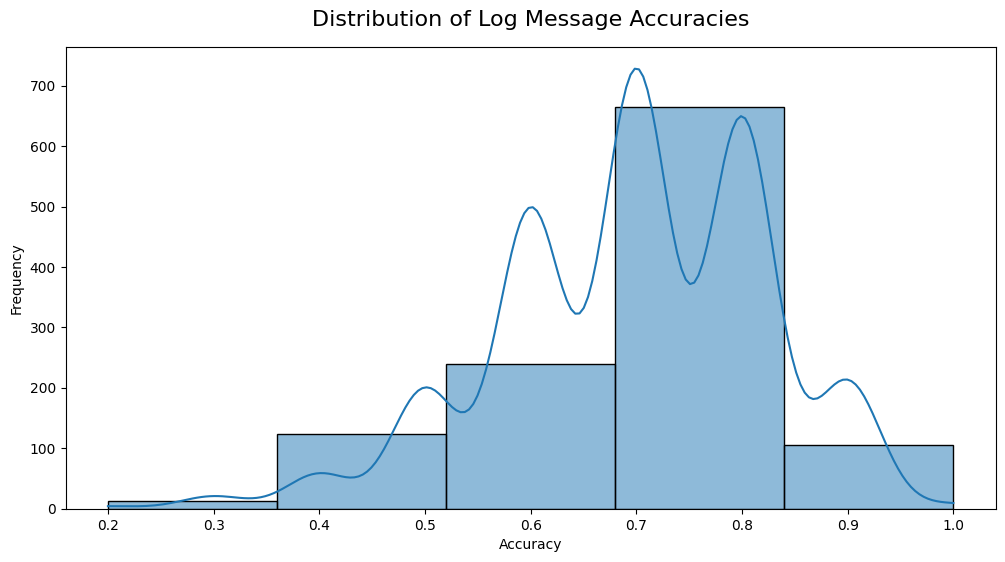

In [14]:
# 1. Distribution of Log Message Accuracies
plt.figure(figsize=(12, 6))
sns.histplot(log_message_accuracies, bins=5, kde=True)
plt.title('Distribution of Log Message Accuracies', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('Accuracy')
plt.ylabel('Frequency')

# Save the plot
output_file_path = os.path.join(output_directory, 'distribution_of_log_message_accuracies.png')
plt.savefig(output_file_path, bbox_inches='tight')

# Show the plot
plt.show()


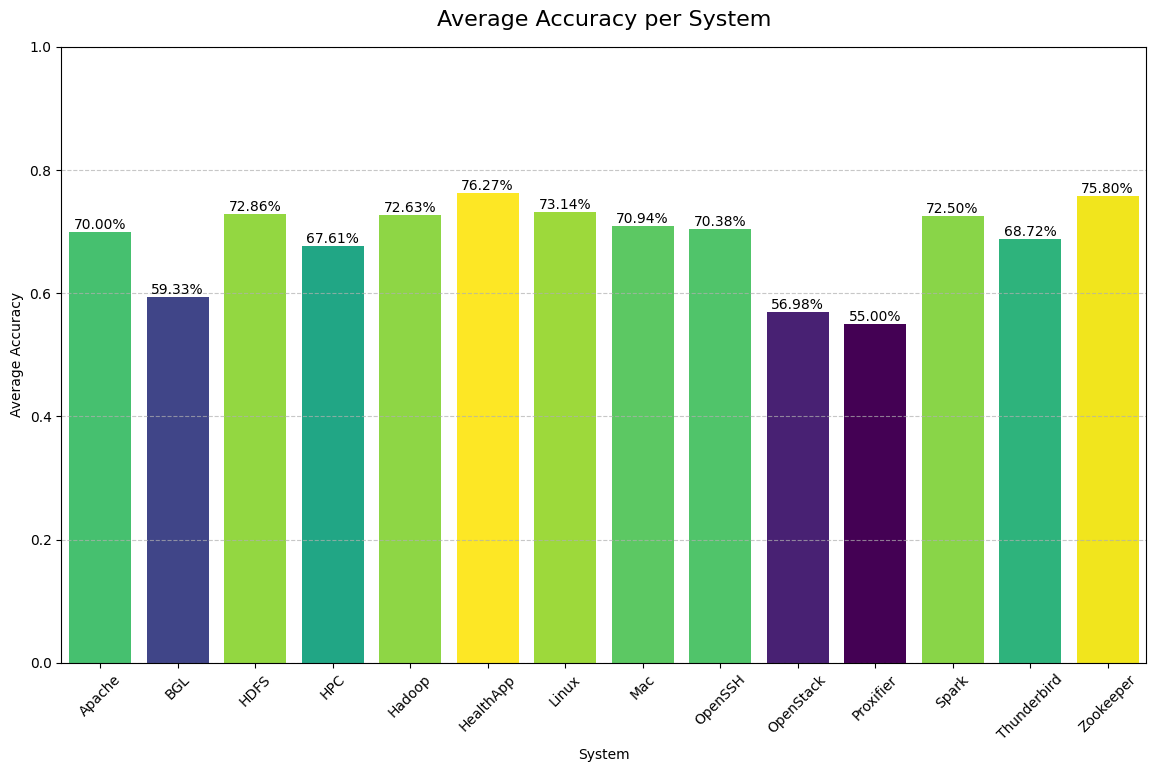

In [15]:
# 2. Plotting System-wise Average Accuracies

# Add the calculated accuracies to the ground truth DataFrame
ground_truth_df['Accuracy'] = log_message_accuracies

# Group by 'System' and calculate average accuracy per system
system_wise_accuracy = ground_truth_df.groupby('System')['Accuracy'].mean()

# Normalize accuracy values for color mapping
norm = mcolors.Normalize(vmin=system_wise_accuracy.min(), vmax=system_wise_accuracy.max())
colors = [cm.viridis(norm(value)) for value in system_wise_accuracy.values]

plt.figure(figsize=(14, 8))
ax = sns.barplot(x=system_wise_accuracy.index, y=system_wise_accuracy.values)

# Assign color to each bar manually to follow the computed color based on accuracy values
for bar, color in zip(ax.patches, colors):
    bar.set_facecolor(color)

# Add title and labels
plt.title('Average Accuracy per System', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('System')
plt.ylabel('Average Accuracy')
plt.ylim(0, 1)

plt.xticks(rotation=45)
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Add data labels to each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

# Save the plot
plt.savefig(os.path.join(output_directory, 'system_wise_average_accuracy.png'), bbox_inches='tight')

plt.show()

/var/folders/qc/zb2ft_d97sscp0wbc3gy2zl40000gn/T/ipykernel_42323/1898627854.py:6: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette=colors)


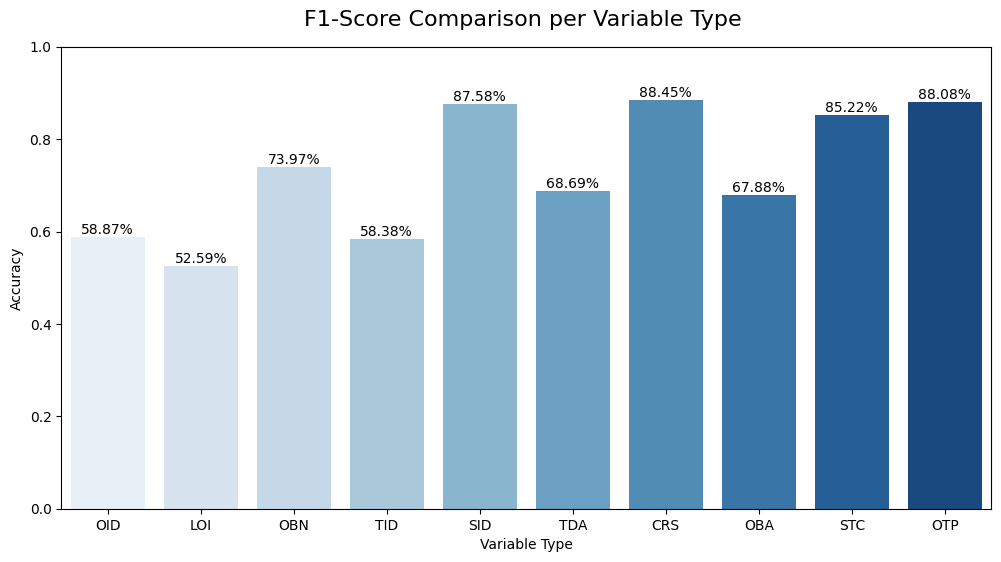

In [18]:
# 3. Per Variable Type Accuracy Comparison with Data Labels
plt.figure(figsize=(12, 6))

# Set color manually using a color map rather than using the deprecated palette without hue
colors = sns.color_palette('Blues', len(f1_scores))
ax = sns.barplot(x=list(f1_scores.keys()), y=list(f1_scores.values()), palette=colors)

# Add data labels on each bar
for p in ax.patches:
    ax.annotate(f'{p.get_height() * 100:.2f}%', 
                (p.get_x() + p.get_width() / 2, p.get_height()), 
                ha='center', va='bottom', fontsize=10, color='black')

plt.title('F1-Score Comparison per Variable Type ', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('Variable Type')
plt.ylabel('Accuracy')
plt.ylim(0, 1)

# Save the plot before showing it
plt.savefig(os.path.join(output_directory, 'per_variable_type_f1-score_comparison.png'), bbox_inches='tight')

plt.show()

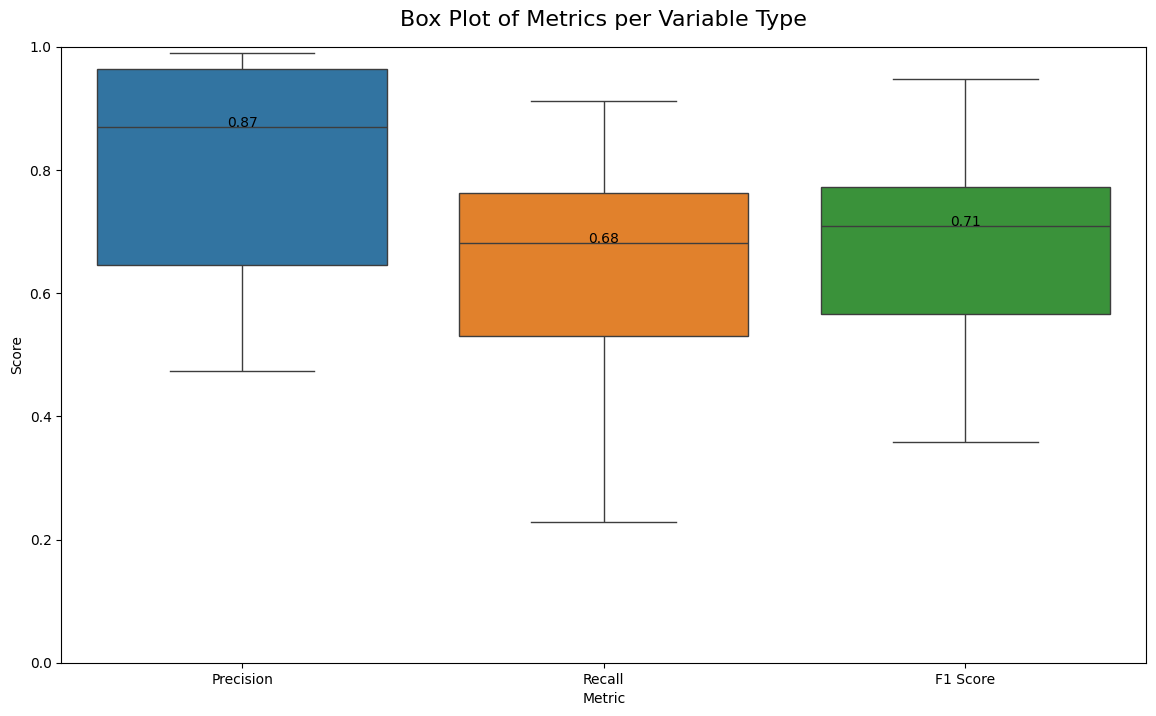

In [24]:
# 4.Box Plot of Metrics Per Variable Type
metrics_all = pd.DataFrame({'Precision': list(precision_scores.values()),
                            'Recall': list(recall_scores.values()),
                            'F1 Score': list(f1_scores.values())}, index=variable_types)
plt.figure(figsize=(14, 8))
ax = sns.boxplot(data=metrics_all)

# Add median value labels on each box
medians = metrics_all.median()

for i, median in enumerate(medians):
    ax.text(i, median, f'{median:.2f}', horizontalalignment='center', color='black', size=10)

plt.title('Box Plot of Metrics per Variable Type', fontsize=16, fontweight='normal', pad=15)
plt.xlabel('Metric')
plt.ylabel('Score')
plt.ylim(0, 1)
# Save the plot before showing it
plt.savefig(os.path.join(output_directory, 'box_plot_of_metrics_per_tariable_type.png'), bbox_inches='tight')

plt.show()


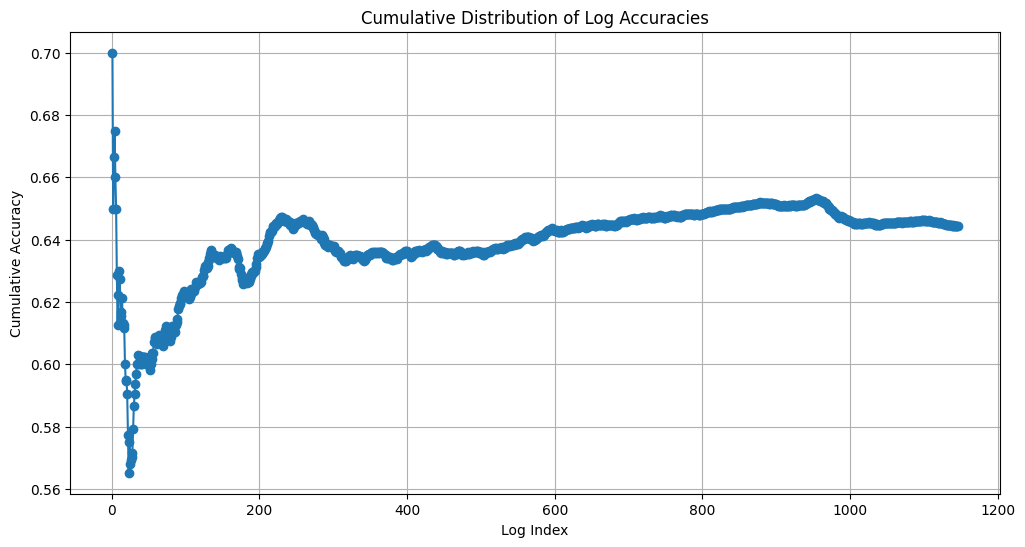

In [25]:
# 5. Cumulative Distribution of Log Accuracy
cumulative_accuracies = np.cumsum(log_message_accuracies) / np.arange(1, len(log_message_accuracies) + 1)
plt.figure(figsize=(12, 6))
plt.plot(range(1, len(cumulative_accuracies) + 1), cumulative_accuracies, marker='o')
plt.title('Cumulative Distribution of Log Accuracies')
plt.xlabel('Log Index')
plt.ylabel('Cumulative Accuracy')
plt.grid(True)
plt.show()